In [13]:
import numpy as np
import pandas as pd
import joblib

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import train_test_split

In [14]:
# Load the data
x = pd.read_csv('x_test_openSmile_emobase.csv')
y = pd.read_csv('y_test_openSmile_emobase.csv')

# Load the models
happy_model = joblib.load('happy_svc_model.pkl')
angry_model = joblib.load('angry_mlp_model.pkl')
disgust_model = joblib.load('disgust_svc_model.pkl')
fearful_model = joblib.load('fearful_mlp_model.pkl')
neutral_model = joblib.load('neutral_mlp_model.pkl')
sad_model = joblib.load('sad_mlp_model.pkl')

binary_models = {
    'happy': happy_model,
    'angry': angry_model,
    'disgust': disgust_model,
    'fearful': fearful_model,
    'neutral': neutral_model,
    'sad': sad_model
}

In [15]:
# Helper function to get probabilities from a pipeline
def pipeline_predict_proba(pipeline, X):
    X_transformed = pipeline[:-1].transform(X)
    return pipeline.steps[-1][1].predict_proba(X_transformed)

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(
    x, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

classes = np.unique(y_test)

# Create a DataFrames to hold the probabilities for each emotion
probs_dict_train = {}
for emotion, model in binary_models.items():
    print(emotion)
    probs = pipeline_predict_proba(model, x_train)[:,1]
    probs_dict_train[f"{emotion}_prob"] = probs.round(5)

probs_dict_test = {}
for emotion, model in binary_models.items():
    print(emotion)
    probs = pipeline_predict_proba(model, x_test)[:,1]
    probs_dict_test[f"{emotion}_prob"] = probs.round(5)

# Final ensembly of probibility DataFrames
x_train_p = pd.DataFrame(probs_dict_train)
scaler = joblib.load('meta_scaler.pkl')
x_train_p = pd.DataFrame(scaler.transform(x_train_p), columns=x_train_p.columns)
x_train_p.head()

x_test_p = pd.DataFrame(probs_dict_test)
x_test_p = pd.DataFrame(scaler.transform(x_test_p), columns=x_test_p.columns)
x_test_p.head()


print(x_test_p)
print(y_test)

happy
angry
disgust
fearful
neutral
sad
happy
angry
disgust
fearful
neutral
sad
     happy_prob  angry_prob  disgust_prob  fearful_prob  neutral_prob  \
0     -0.987130    -1.00000      0.506101      -1.00000      -0.99228   
1     -0.752454    -0.30112     -0.951792      -0.99994       0.68154   
2     -0.802226     0.99998     -0.994099      -1.00000       0.79754   
3     -0.857180    -1.00000     -0.250040      -0.99976      -0.99970   
4      0.438422    -1.00000     -0.989318      -0.39496      -1.00000   
..          ...         ...           ...           ...           ...   
123   -0.919184    -0.99998     -0.566031      -0.99998      -0.99804   
124   -0.994346    -1.00000     -0.856617      -1.00000       0.73294   
125   -0.091475    -1.00000     -0.999560      -1.00000       0.95722   
126   -0.898420    -0.83640     -0.416307      -0.99602      -1.00000   
127   -0.956025    -1.00000      0.639822      -1.00000      -0.19868   

     sad_prob  
0     0.87724  
1    -0.955

C:\Users\jbkee\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Classification Report:
              precision    recall  f1-score   support

       angry       0.83      0.76      0.79        25
     disgust       0.67      0.70      0.68        20
     fearful       0.76      0.76      0.76        21
       happy       0.67      0.73      0.70        22
     neutral       0.63      0.63      0.63        19
         sad       0.65      0.62      0.63        21

    accuracy                           0.70       128
   macro avg       0.70      0.70      0.70       128
weighted avg       0.71      0.70      0.70       128



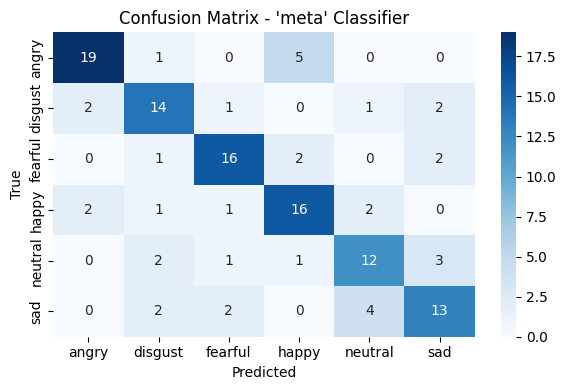

In [16]:
# Testing data with basic Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=42)
meta_model_lr = lr.fit(x_train_p, y_train)
y_pred = meta_model_lr.predict(x_test_p)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=classes))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(
    cm, 
    annot=True, 
    fmt="d", 
    cmap="Blues",
    xticklabels=classes,
    yticklabels=classes
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix - 'meta' Classifier")
plt.tight_layout()
plt.show()

C:\Users\jbkee\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Classification Report:
              precision    recall  f1-score   support

       angry       0.73      0.76      0.75        25
     disgust       0.62      0.65      0.63        20
     fearful       0.85      0.81      0.83        21
       happy       0.67      0.64      0.65        22
     neutral       0.62      0.68      0.65        19
         sad       0.63      0.57      0.60        21

    accuracy                           0.69       128
   macro avg       0.69      0.69      0.68       128
weighted avg       0.69      0.69      0.69       128



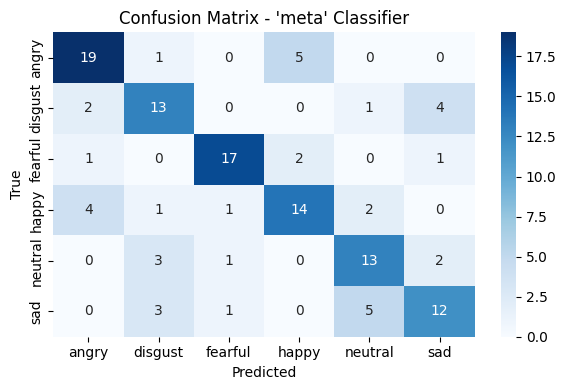

In [17]:
# Testing data with Random Forest Classifier
meta_model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
meta_model_rf.fit(x_train_p, y_train)

y_pred = meta_model_rf.predict(x_test_p)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=classes))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(
    cm, 
    annot=True, 
    fmt="d", 
    cmap="Blues",
    xticklabels=classes,
    yticklabels=classes
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix - 'meta' Classifier")
plt.tight_layout()
plt.show()

C:\Users\jbkee\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Classification Report:
              precision    recall  f1-score   support

       angry       0.87      0.80      0.83        25
     disgust       0.63      0.60      0.62        20
     fearful       0.80      0.76      0.78        21
       happy       0.65      0.68      0.67        22
     neutral       0.63      0.63      0.63        19
         sad       0.54      0.62      0.58        21

    accuracy                           0.69       128
   macro avg       0.69      0.68      0.68       128
weighted avg       0.69      0.69      0.69       128



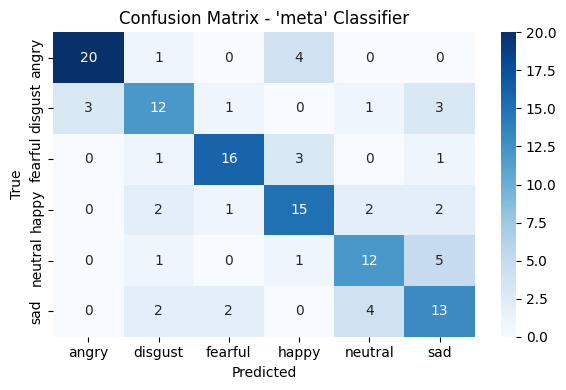

In [18]:
# Testing data with MLP Classifier
mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation="relu",
    solver="adam",
    alpha=1e-3,
    learning_rate_init=1e-3,
    max_iter=1000,
    random_state=42,
    verbose=False
)

meta_model_mlp = mlp.fit(x_train_p, y_train)

y_pred = meta_model_mlp.predict(x_test_p)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=classes))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(
    cm, 
    annot=True, 
    fmt="d", 
    cmap="Blues",
    xticklabels=classes,
    yticklabels=classes
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix - 'meta' Classifier")
plt.tight_layout()
plt.show()

In [19]:
#joblib.dump(meta_model_mlp, 'meta_model_mlp.pkl')

C:\Users\jbkee\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Classification Report:
              precision    recall  f1-score   support

       angry       0.83      0.76      0.79        25
     disgust       0.62      0.65      0.63        20
     fearful       0.74      0.81      0.77        21
       happy       0.70      0.73      0.71        22
     neutral       0.61      0.58      0.59        19
         sad       0.60      0.57      0.59        21

    accuracy                           0.69       128
   macro avg       0.68      0.68      0.68       128
weighted avg       0.69      0.69      0.69       128



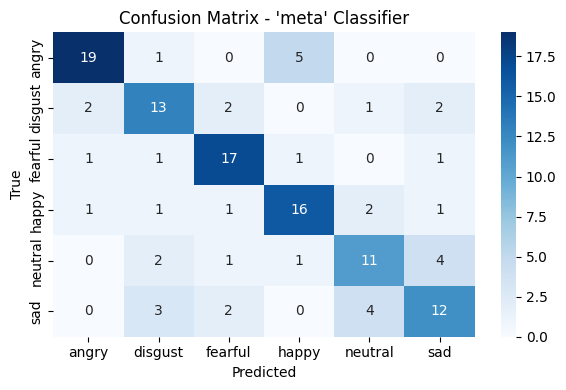

In [20]:
# Testing data with SVC Classifier
svc = SVC(kernel="rbf", probability=True, random_state=42)
meta_model_svc = svc.fit(x_train_p, y_train)
y_pred = meta_model_svc.predict(x_test_p)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=classes))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(
    cm, 
    annot=True, 
    fmt="d", 
    cmap="Blues",
    xticklabels=classes,
    yticklabels=classes
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix - 'meta' Classifier")
plt.tight_layout()
plt.show()


C:\Users\jbkee\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jbkee\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)



Classification Report:
              precision    recall  f1-score   support

       angry       0.80      0.80      0.80        25
     disgust       0.74      0.70      0.72        20
     fearful       0.76      0.76      0.76        21
       happy       0.67      0.73      0.70        22
     neutral       0.68      0.68      0.68        19
         sad       0.70      0.67      0.68        21

    accuracy                           0.73       128
   macro avg       0.72      0.72      0.72       128
weighted avg       0.73      0.73      0.73       128



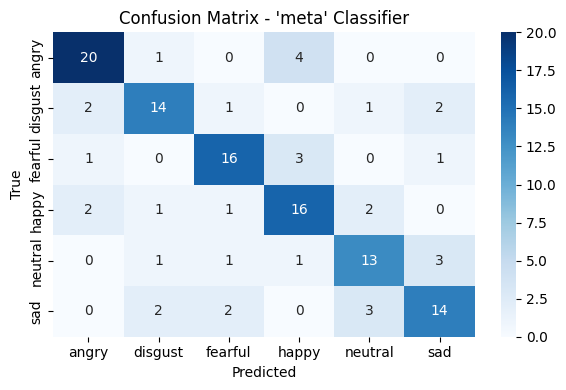

In [21]:
# Testing data with Stacking Classifier
base_models = [
    ('lr', lr),
    ('mlp', mlp),
    ('svc', svc),
    #('knn', KNeighborsClassifier(n_neighbors=4)),
    ('et', ExtraTreesClassifier(n_estimators=100, random_state=42))
]
meta_model = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression())
meta_model.fit(x_train_p, y_train)
y_pred = meta_model.predict(x_test_p)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=classes))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(
    cm, 
    annot=True, 
    fmt="d", 
    cmap="Blues",
    xticklabels=classes,
    yticklabels=classes
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix - 'meta' Classifier")
plt.tight_layout()
plt.show()

In [22]:
# Load general MLP model and scaler
general_mlp_model = joblib.load('general_mlp_model.pkl')
mlp_prob_scaler = joblib.load('mlp_prob_scaler.pkl')

# Get probabilities from the general MLP model
general_probs = general_mlp_model.predict_proba(x_test)
general_probs = mlp_prob_scaler.transform(general_probs)
general_probs = pd.DataFrame(general_probs, columns=general_mlp_model.classes_)

print(general_probs.shape)

# Create a new data frame with -1 in each cell
meta_input = pd.DataFrame(-1, index=range(general_probs.shape[0]), columns=['happy_prob', 'angry_prob', 'disgust_prob', 'fearful_prob', 'neutral_prob', 'sad_prob'])
print(meta_input)

# Get the top 3 probabilities for each row in general_probs
best = np.argsort(general_probs, axis=1)[:, -1]
second_best = np.argsort(general_probs, axis=1)[:, -2]
#third_best = np.argsort(general_probs, axis=1)[:, -3]

# Replace the -1 values with the corresponding probabilities from x_test_p where the indices match our top 3 from general_probs
for i in range(general_probs.shape[0]):
    meta_input.iloc[i, best[i]] = x_test_p.iloc[i, best[i]]
    meta_input.iloc[i, second_best[i]] = x_test_p.iloc[i, second_best[i]]
    #meta_input.iloc[i, third_best[i]] = x_test_p.iloc[i, third_best[i]]

print(meta_input[:25])

C:\Users\jbkee\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


ValueError: X has 988 features, but MLPClassifier is expecting 379 features as input.


Classification Report:
              precision    recall  f1-score   support

       angry       0.33      0.08      0.13        25
     disgust       0.75      0.15      0.25        20
     fearful       0.50      0.62      0.55        21
       happy       0.30      0.36      0.33        22
     neutral       0.58      0.58      0.58        19
         sad       0.35      0.76      0.48        21

    accuracy                           0.41       128
   macro avg       0.47      0.43      0.39       128
weighted avg       0.46      0.41      0.38       128



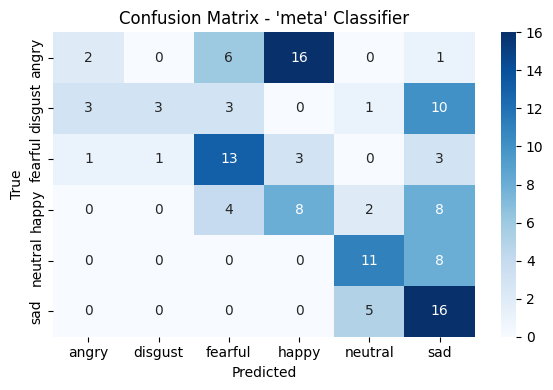

In [23]:

# Test the meta model
meta_predictions = meta_model.predict(meta_input)

print("\nClassification Report:")
print(classification_report(y_test, meta_predictions, target_names=classes))

cm = confusion_matrix(y_test, meta_predictions)

plt.figure(figsize=(6, 4))
sns.heatmap(
    cm, 
    annot=True, 
    fmt="d", 
    cmap="Blues",
    xticklabels=classes,
    yticklabels=classes
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix - 'meta' Classifier")
plt.tight_layout()
plt.show()